## Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
from scipy import sparse
from anndata import AnnData
import warnings
import socket
import plotly.express as px
from matplotlib import pylab
from matplotlib.colors import TwoSlopeNorm
import gseapy

import sys
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles

warnings.filterwarnings('ignore')

/group/testa/Users/davide.castaldi/Polaroid_publication_revisions/.local/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==56.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [2]:

FinaLeaf="/Progenitors"
outdir="./outdir"

ThreePointsDEGs = outdir+FinaLeaf+"/03B_Badhuri_Progenitors.3pointsModel.pBulk_byArea.scaled.DEGs.filtered.tsv"

adataPath = outdir+FinaLeaf+"/5B_Progenitors_pBulk.bySegment.10PRs.h5ad"
groupingCovariate = "regionContrast"
adataPathBadhuri = outdir+FinaLeaf+"/Badhuri_progenitors_pBulk.Curated.20PRs.bycortical_area.h5ad"
RelevantAreas = ["pfc","temporal","somatosensory"]

if not os.path.exists('./figures'):
    os.makedirs('./figures')

if not os.path.exists('./tables'):
    os.makedirs('./tables')


In [3]:
print(pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0).sort_values(by = "FWER", ascending = True).shape)


(255, 7)


In [4]:
%matplotlib inline

In [5]:
sc.settings.verbosity = 3         # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')
pylab.rcParams['figure.figsize'] = (10, 10)


scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.22.2 scipy==1.10.1 pandas==1.2.3 scikit-learn==0.24.2 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


### Configure paths

In [6]:
hostRoot = "-".join(socket.gethostname().split('-')[0:2])

with open(os.path.expanduser('~')+"/paths_config.yaml", 'r') as f:
    paths = yaml.load(f, Loader=yaml.FullLoader)

#indir=paths["paths"]["indir"][hostRoot]
#projectBaseDir=paths["paths"]["projectBaseDir"][hostRoot]



## 3 points model DEGs

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=29
    finished (0:00:00)


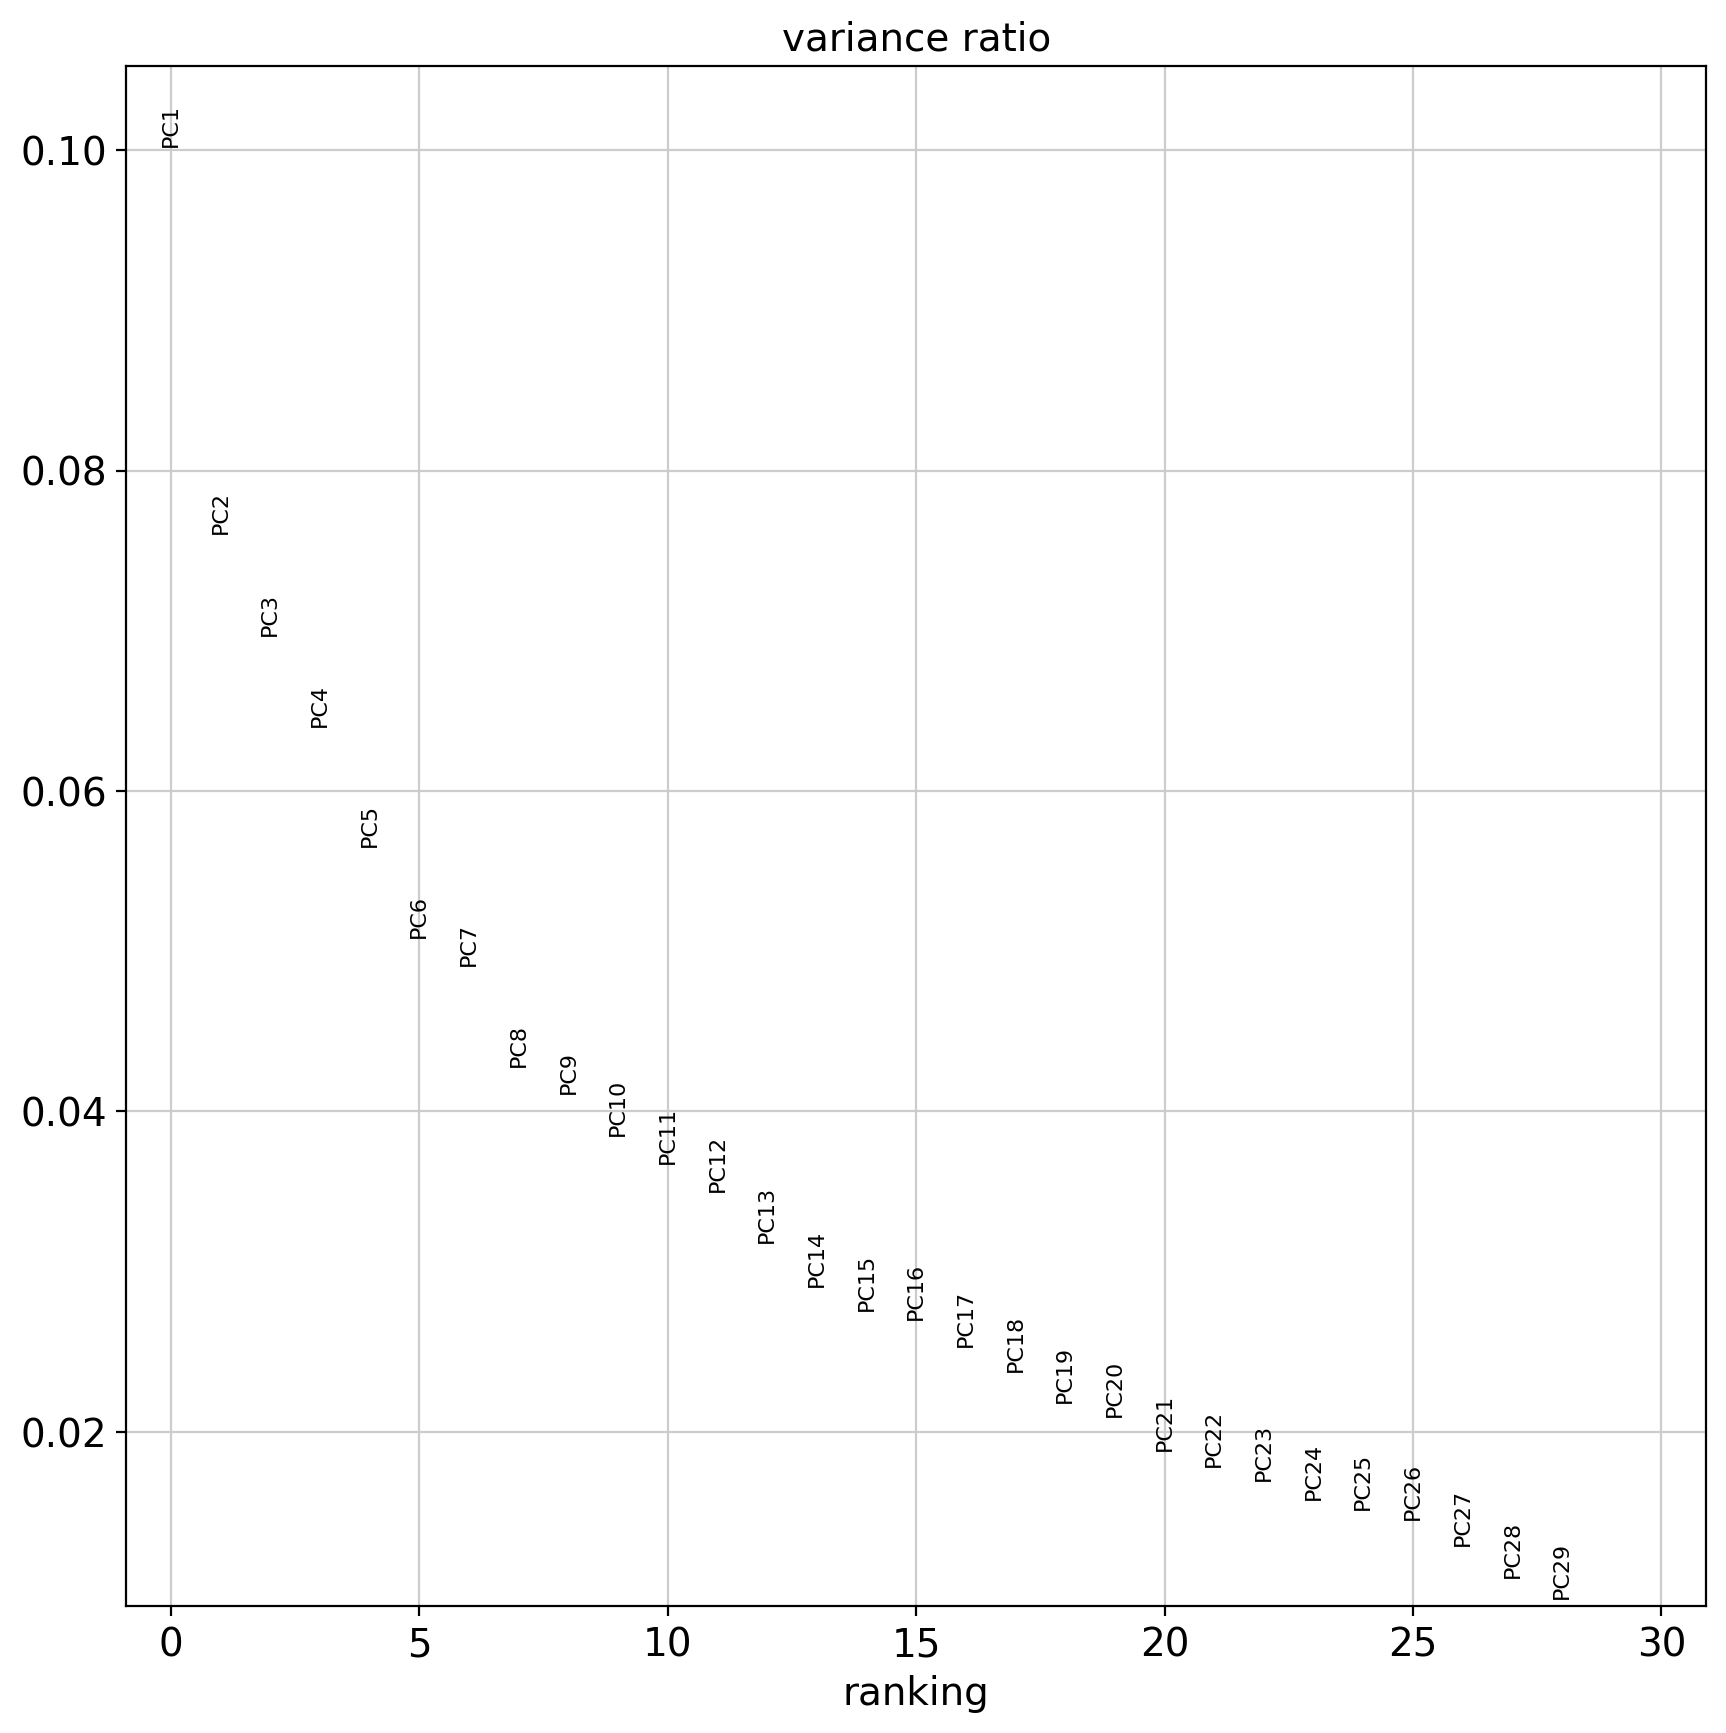

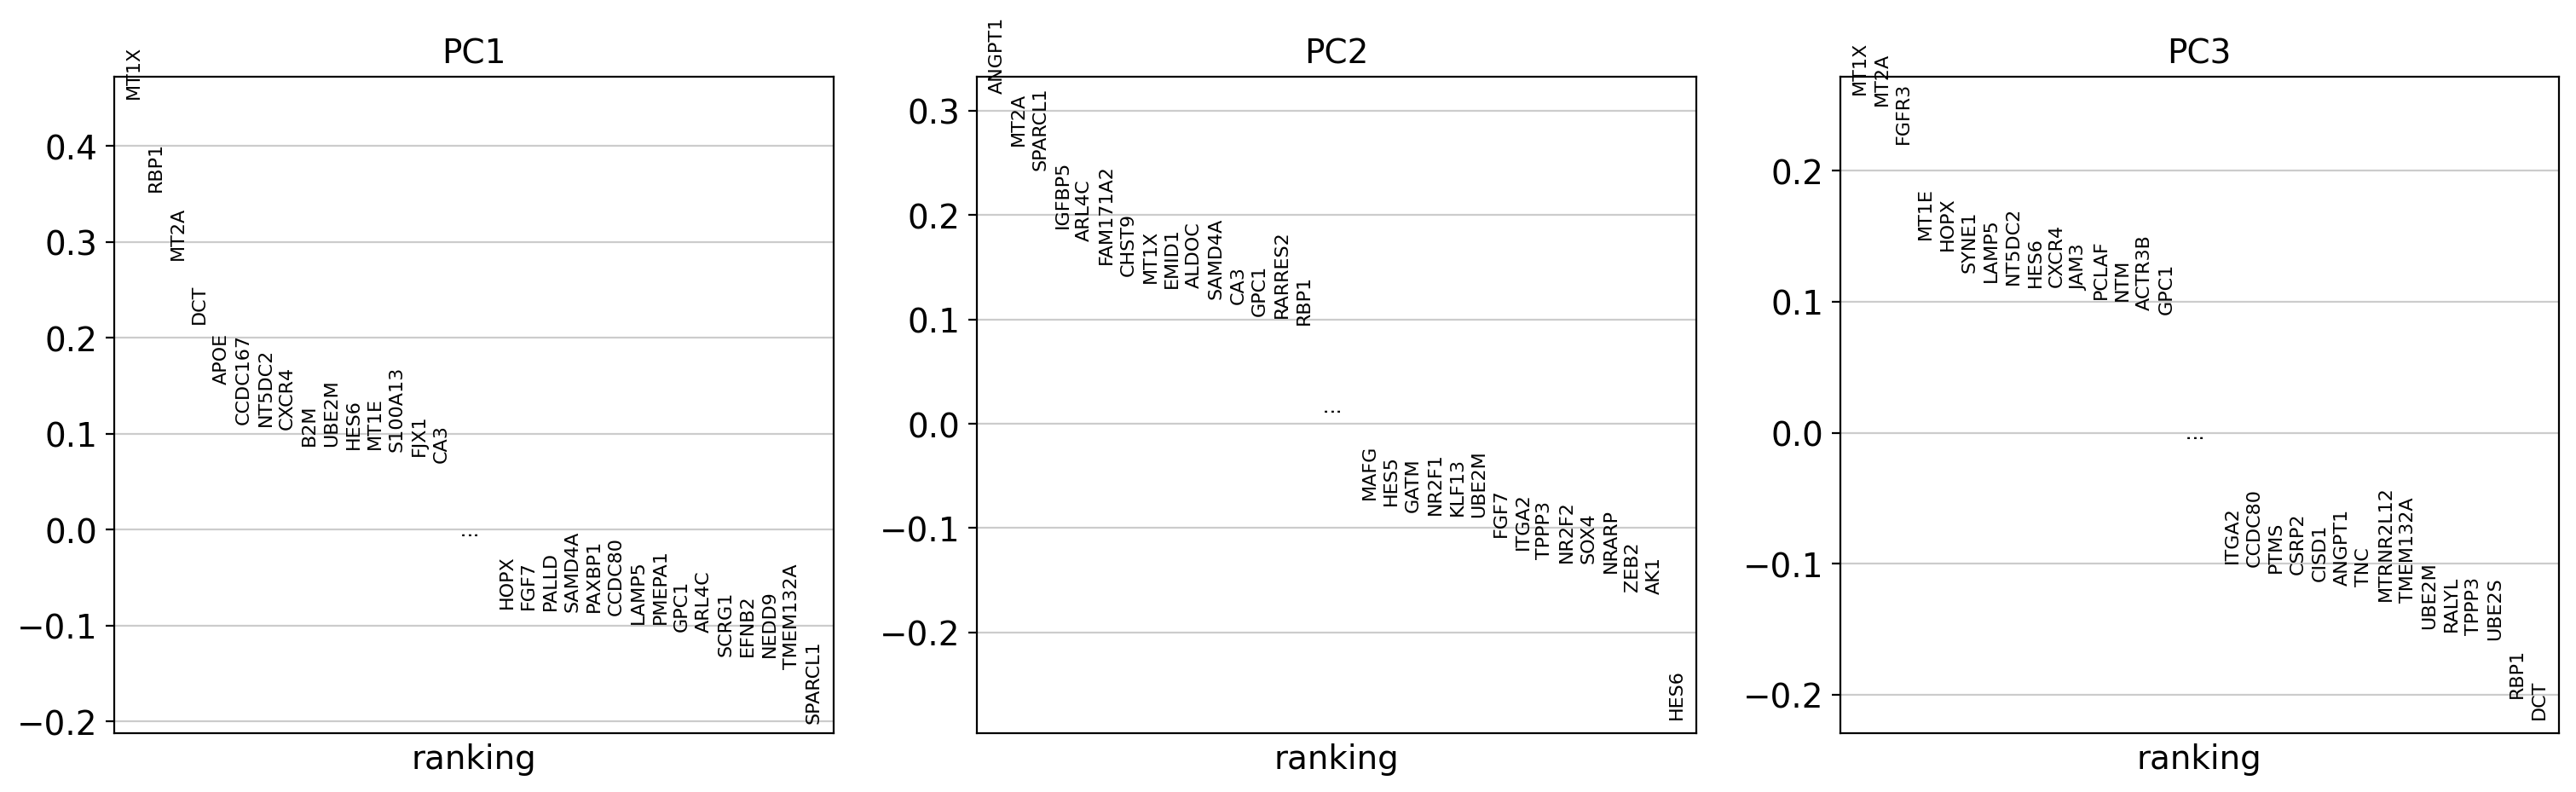

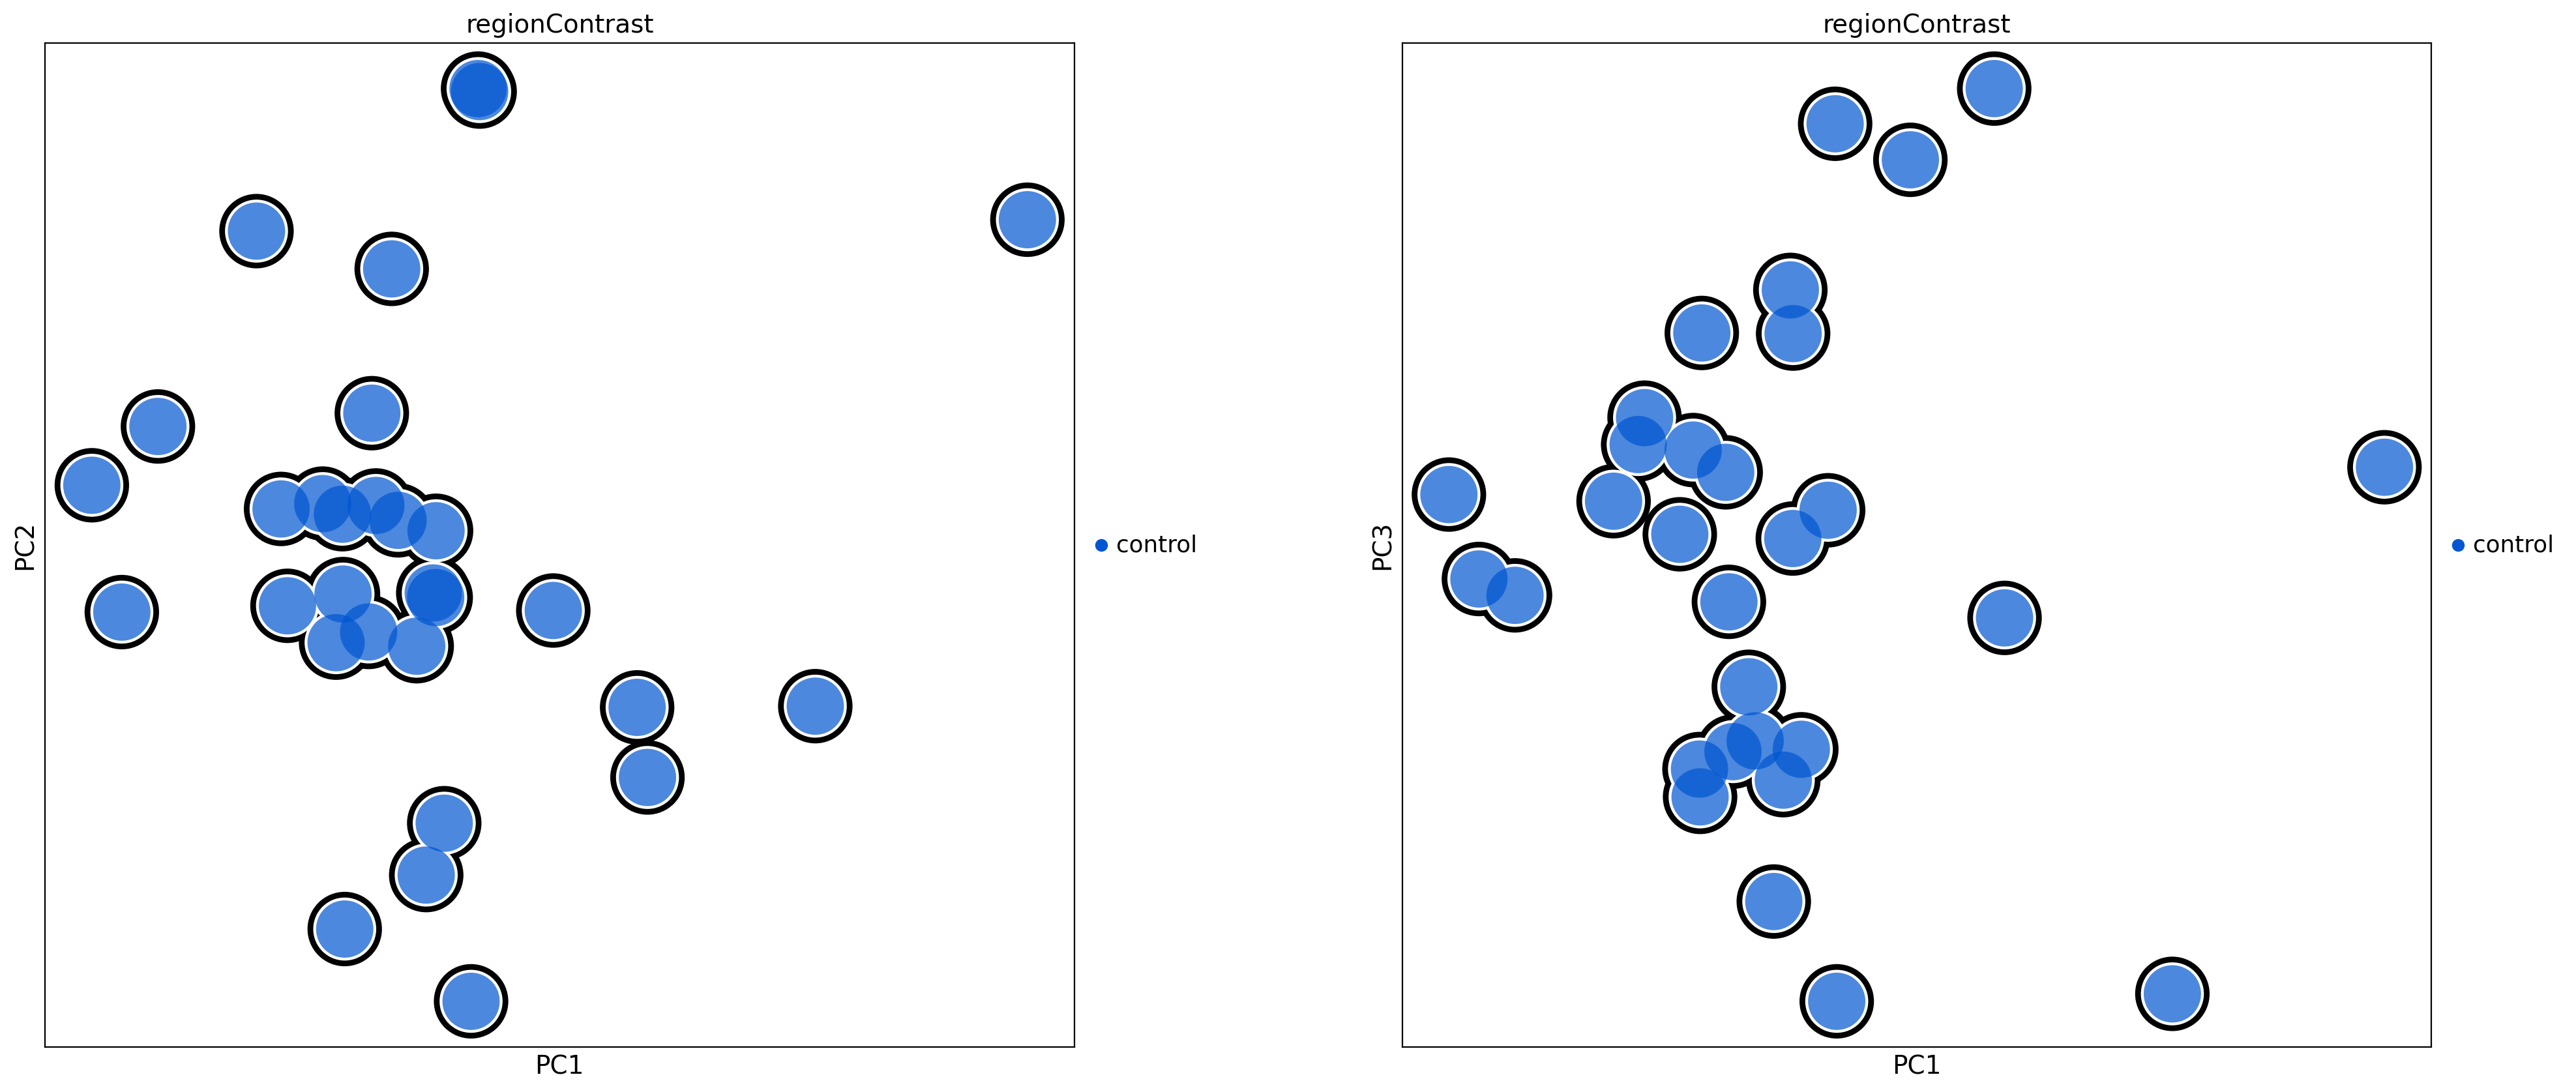

In [7]:

adata = sc.read_h5ad(adataPath)
adata=adata[adata.obs["type"] == "control"]

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
NowaDEGs_3Points = pd.read_csv(ThreePointsDEGs, sep = "\t", index_col=0)
adata = adata[:,list(set(adata.var_names).intersection(NowaDEGs_3Points.index))]
#sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, use_highly_variable=False)

sc.pl.pca_variance_ratio(adata)

pylab.rcParams['figure.figsize'] = (6, 5)
sc.pl.pca_loadings(adata)

pylab.rcParams['figure.figsize'] = (10, 10)


#sc.pl.pca(adata, components=['1,2','1,3'], color=[groupingCovariate]+[m for m in highConf if m in adata.var_names.tolist()], ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)
sc.pl.pca(adata, components=['1,2','1,3'], color=[groupingCovariate], ncols=2, add_outline=True, outline_width=(.1,.05), wspace=.2, show=False)


#store varm pca for later projection
loadings = adata.varm["PCs"]

In [8]:
# Proximal/pfc/piece1 always right left
if adata[adata.obs["group"] == "piece1"].obsm["X_pca"][:,0].mean() > adata[adata.obs["group"] == "piece"].obsm["X_pca"][:,0].mean():
    adata.varm["PCs"] = -adata.varm["PCs"]
    adata.obsm["X_pca"] = -adata.obsm["X_pca"]


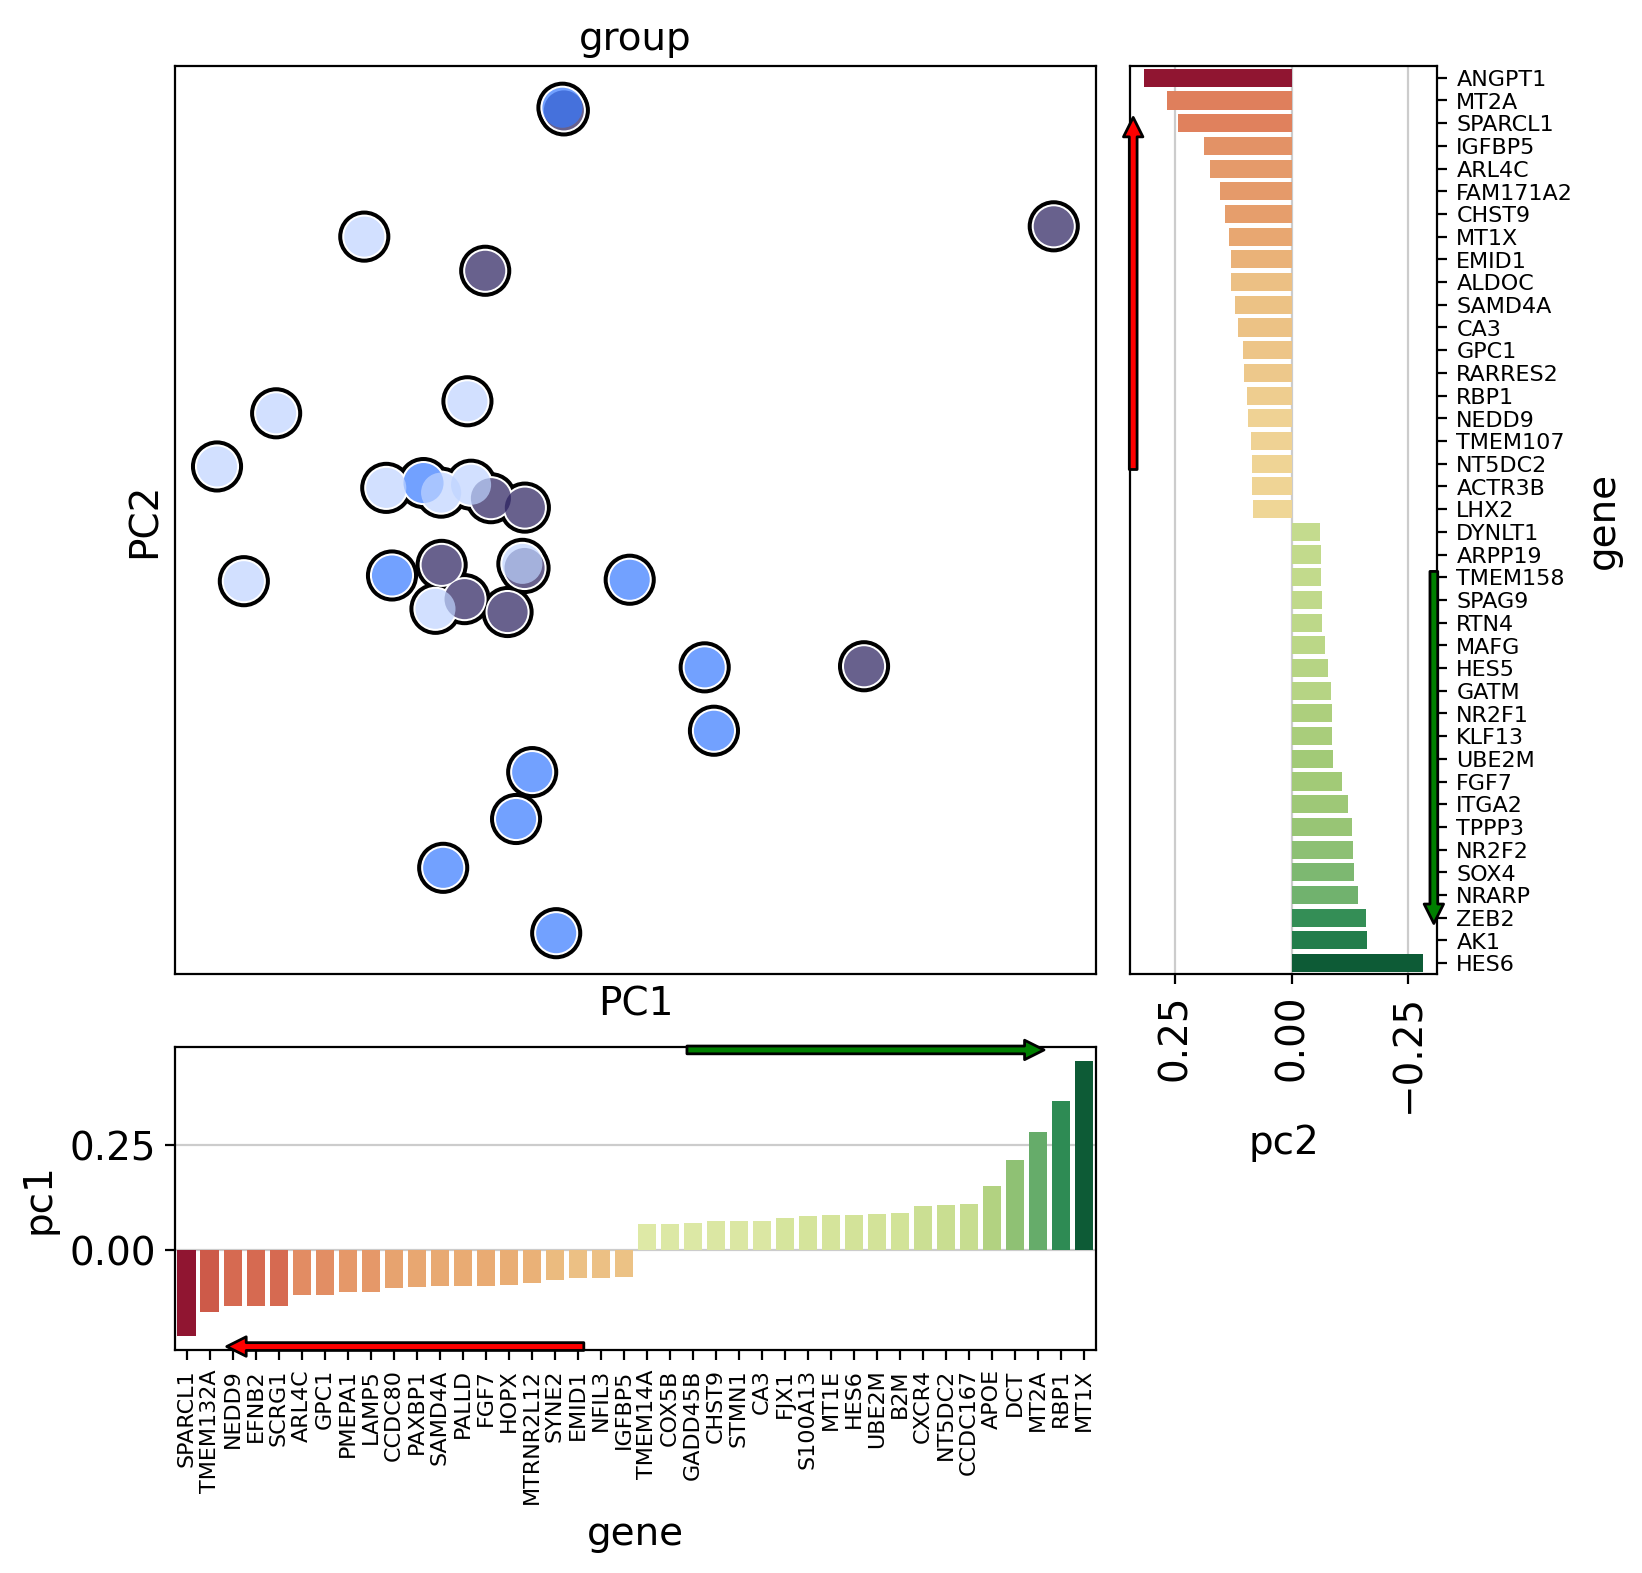

In [9]:
#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
color="group"
pcsToAssess = [0,1]
adataObj = adata


##################


dotsize = 25000/adataObj.shape[0]

pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  pcsToAssess:
    TopPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataObj.varm["PCs"][:,pc][TopPC_IDX], index = adataObj.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataObj.varm["PCs"][:,pc][DownPC_IDX], index = adataObj.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == pcsToAssess[0]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == pcsToAssess[1]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (n/3.3333, n/3.3333)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataObj, components=",".join([str(i+1) for i in pcsToAssess]), color=[color], 
                    ncols=1, add_outline=True, legend_loc="None",size=dotsize,legend_fontsize="xx-small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)]]
sns.barplot(data=pdDict[pcsToAssess[0]], x="gene", y="pc"+str(pcsToAssess[0]+1), hue="pc"+str(pcsToAssess[0]+1),palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[1][0].get_legend().remove()


norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)]]
sns.barplot(data=pdDict[pcsToAssess[1]], x="pc"+str(pcsToAssess[1]+1), y="gene", hue="pc"+str(pcsToAssess[1]+1),palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].get_legend().remove()
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

In [10]:
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])
    

In [11]:
fig.savefig("./figures/"+nb_fname+".PCA.pdf",
           bbox_inches="tight")

In [12]:
obsTable = adataObj.obs.copy()
obsTable["PC1"] = adata.obsm["X_pca"][:,0].flatten()
obsTable["PC2"] = adata.obsm["X_pca"][:,1].flatten()
obsTable
obsTable.to_excel("./tables/MainFig6B.progenitors.loadings.xlsx")

pd.concat([
    pdDict[0].rename(columns={"pc1":"loading"}).assign(component=1),
    pdDict[1].rename(columns={"pc2":"loading"}).assign(component=2)],
          ignore_index=True).to_excel("./tables/MainFig6B.progenitors.PCA.xlsx")

# Load badhuri pBulk

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


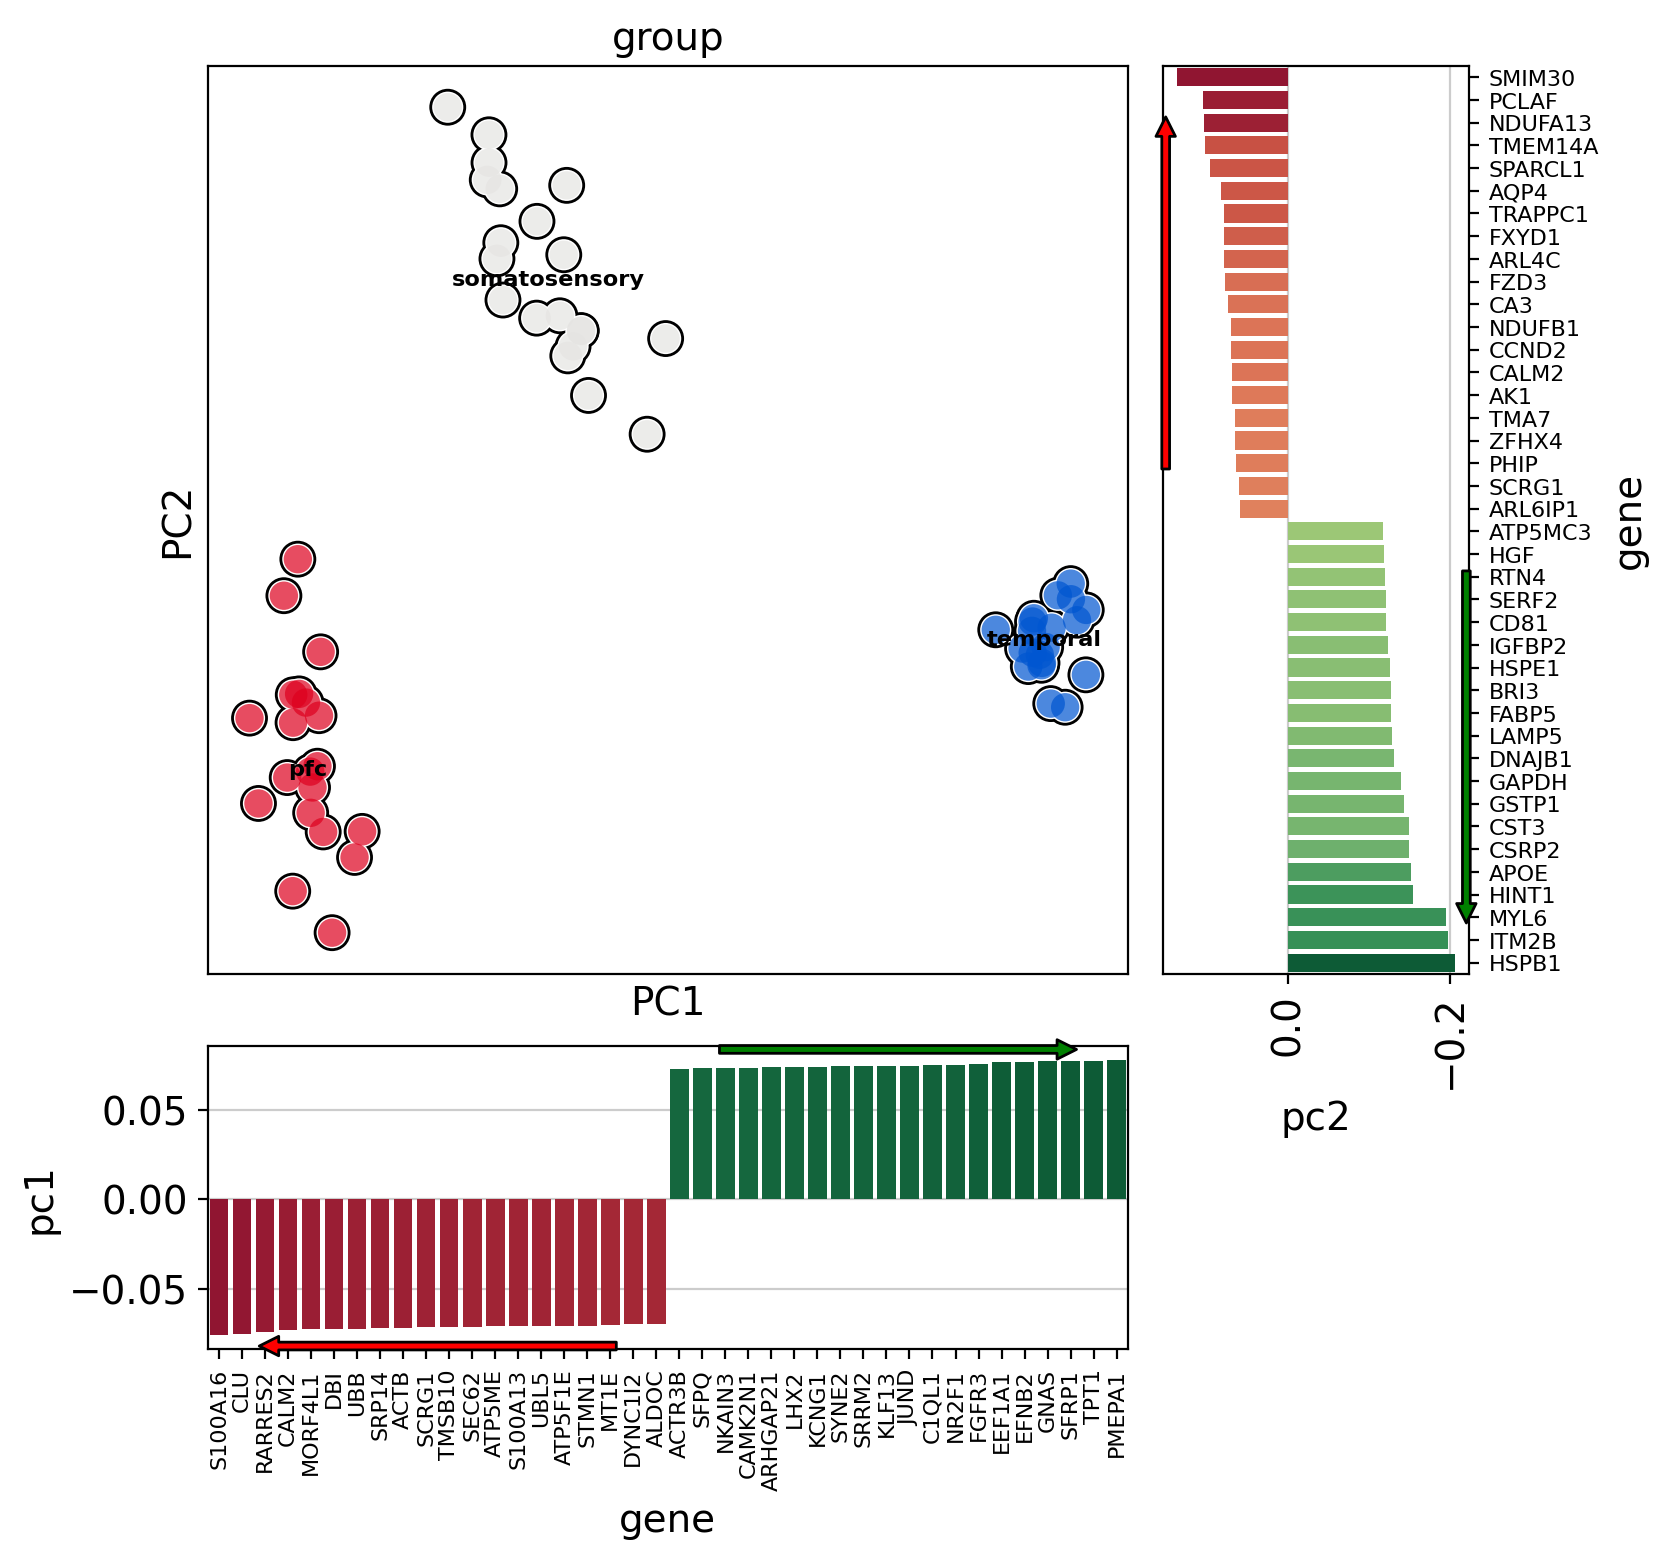

In [13]:
# Load badhuri pBulk

adataBadhuri = sc.read_h5ad(adataPathBadhuri)
adataBadhuri = adataBadhuri[adataBadhuri.obs["group"].isin(RelevantAreas)]

sc.pp.normalize_total(adataBadhuri, target_sum=2e4)
sc.pp.log1p(adataBadhuri)
adataBadhuri.raw = adataBadhuri.copy()




GenesIntersectioin  = adataBadhuri.var_names.intersection(adata.var_names)

adataBadhuri = adataBadhuri[:,GenesIntersectioin]

sc.pp.scale(adataBadhuri)

sc.tl.pca(adataBadhuri, use_highly_variable=False)

if adataBadhuri[adataBadhuri.obs["group"] == "pfc"].obsm["X_pca"][:,0].mean() > adataBadhuri[adataBadhuri.obs["group"] == "temporal"].obsm["X_pca"][:,0].mean():
    adataBadhuri.varm["PCs"] = -adataBadhuri.varm["PCs"]
    adataBadhuri.obsm["X_pca"] = -adataBadhuri.obsm["X_pca"]


#if you want vector sc.settings._vector_friendly = False
vector=True
n=20
color="group"
pcsToAssess = [0,1]
adataObj = adataBadhuri


##################


dotsize = 25000/adataObj.shape[0]

pdDict = {}
if vector:
    sc.settings._vector_friendly = False
for pc in  pcsToAssess:
    TopPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], -n)[-n:]
    DownPC_IDX = np.argpartition(adataObj.varm["PCs"][:,pc], n)[:n]
    pdDict[pc] = pd.DataFrame(adataObj.varm["PCs"][:,pc][TopPC_IDX], index = adataObj.var_names[TopPC_IDX], columns=["pc"+str(pc+1)])
    pdDict[pc] = pd.concat([pdDict[pc],pd.DataFrame(adataObj.varm["PCs"][:,pc][DownPC_IDX], index = adataObj.var_names[DownPC_IDX], columns=["pc"+str(pc+1)])])
    pdDict[pc]["gene"] = pdDict[pc].index.tolist()
    if pc == pcsToAssess[0]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1))
    elif pc == pcsToAssess[1]:
        pdDict[pc] = pdDict[pc].sort_values("pc"+str(pc+1), ascending = False)
    
    
    

figsize = (n/3.3333, n/3.3333)  #(width, height)
#Set axes
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,gridspec_kw={'width_ratios': [3, 1],'height_ratios': [3, 1]})

fig.tight_layout(pad=-2, h_pad=0)   #space between plots

ax1plot = sc.pl.pca(adataObj, components=",".join([str(i+1) for i in pcsToAssess]), color=[color], 
                    ncols=1, add_outline=True, legend_loc="on data",size=dotsize,legend_fontsize="xx-small",
                    outline_width=(.1,.05), wspace=.2, show=False, ax=ax[0][0])



norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[0]]["pc"+str(pcsToAssess[0]+1)]]
sns.barplot(data=pdDict[pcsToAssess[0]], x="gene", y="pc"+str(pcsToAssess[0]+1), hue="pc"+str(pcsToAssess[0]+1),palette=colors,ax=ax[1][0], zorder=3 ).tick_params(axis='x', rotation=90, labelsize=8)
ax[1][0].annotate("", xy=(.95,.99),xytext=(0.55, 0.99),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))
ax[1][0].annotate("", xy=(.05,.01),xytext=(0.45, 0.01),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[1][0].get_legend().remove()


norm = TwoSlopeNorm(vmin=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].min(), vcenter=0, vmax=pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)].max())
colors = [plt.cm.RdYlGn(norm(c)) for c in pdDict[pcsToAssess[1]]["pc"+str(pcsToAssess[1]+1)]]
sns.barplot(data=pdDict[pcsToAssess[1]], x="pc"+str(pcsToAssess[1]+1), y="gene", hue="pc"+str(pcsToAssess[1]+1),palette=colors,ax=ax[0][1], zorder=3 ).tick_params(axis='y',  
                                                                                                              labelsize=8, 
                                                                                                              labelright=True, labelleft=False,
                                                                                                              right=True, left=False)
ax[0][1].get_legend().remove()
ax[0][1].tick_params(axis='x', rotation=90)

ax[0][1].annotate("", xy=(.01,.95),xytext=(0.01, 0.55),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="red"))
ax[0][1].annotate("", xy=(.99,.05),xytext=(0.99, 0.45),
                  xycoords='axes fraction',
                  arrowprops=dict(arrowstyle="simple",facecolor="green"))



ax[0][1].invert_xaxis()
ax[0][1].yaxis.set_label_position("right")
fig.delaxes(ax[1][1])

sc.settings._vector_friendly = True

2024-05-11 09:36:31,748 [WARNING] Duplicated values found in preranked stats: 1.22% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-11 09:36:31,749 [INFO] Parsing data files for GSEA.............................
2024-05-11 09:36:31,749 [INFO] 0000 gene_sets have been filtered out when max_size=5000 and min_size=1
2024-05-11 09:36:31,750 [INFO] 0002 gene_sets used for further statistical testing.....
2024-05-11 09:36:31,750 [INFO] Start to run GSEA...Might take a while..................
2024-05-11 09:36:31,756 [INFO] Congratulations. GSEApy runs successfully................



< 0.01
< 0.01


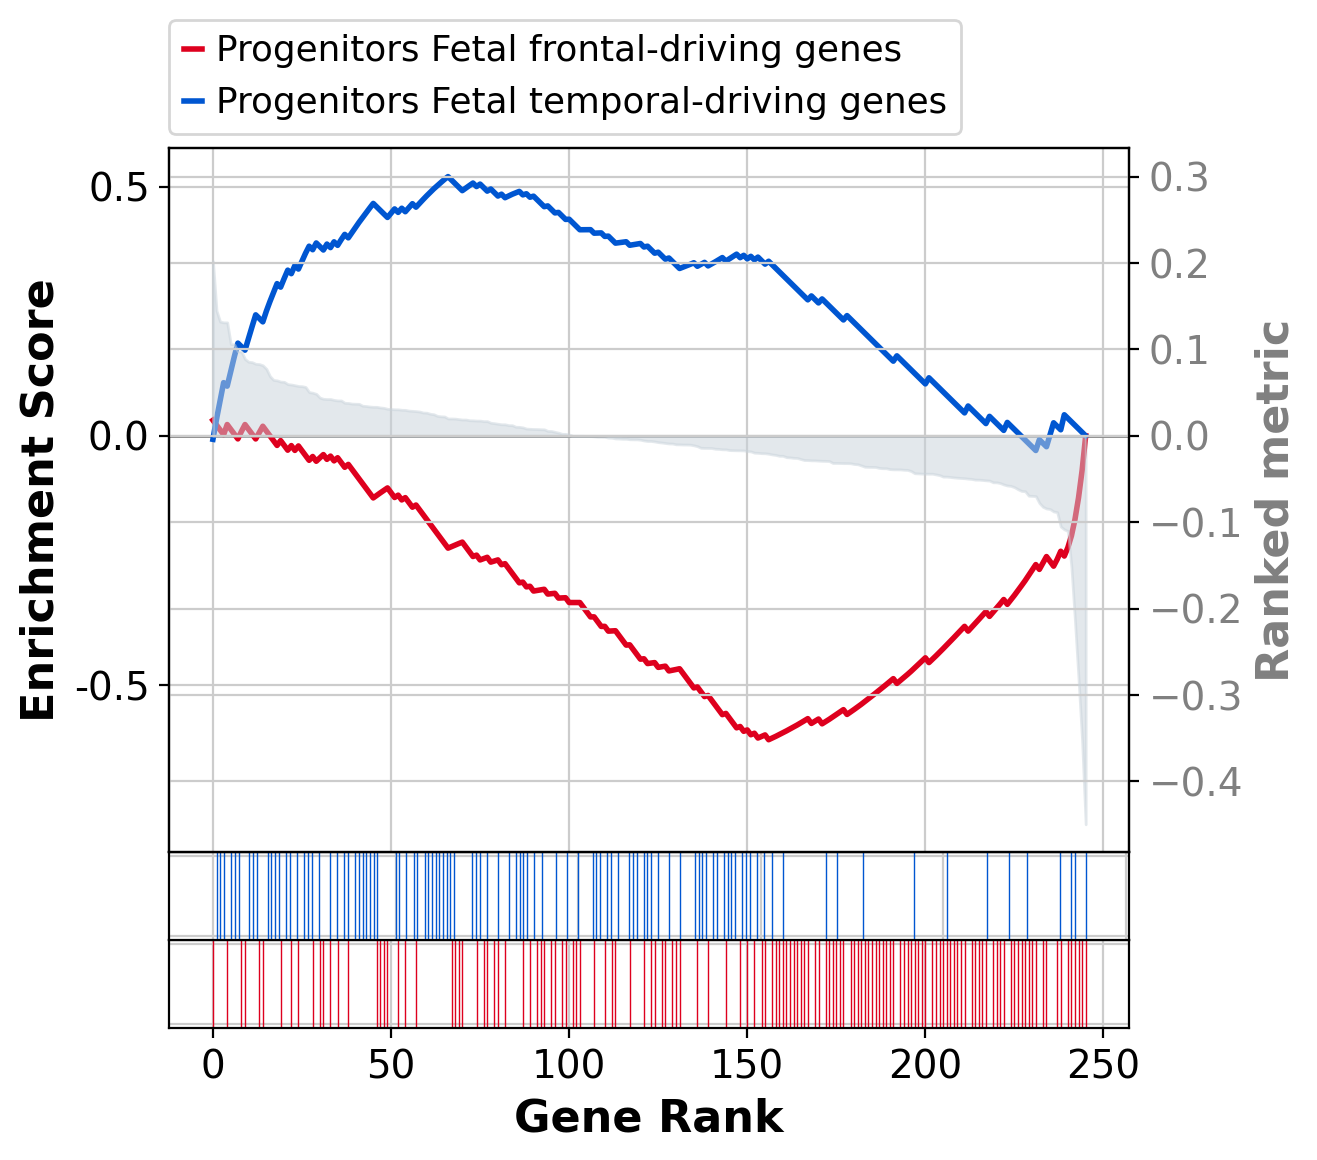

In [14]:
from matplotlib.lines import Line2D



Loadings = pd.DataFrame({"GeneLoading":adataBadhuri.varm["PCs"][:,0],"GeneName":adataBadhuri.var_names.tolist()}, index=adataBadhuri.var_names.tolist()).sort_values("GeneLoading")
if adataBadhuri[adataBadhuri.obs["group"] == "pfc"].obsm["X_pca"][:,0].mean() > adataBadhuri[adataBadhuri.obs["group"] == "temporal"].obsm["X_pca"][:,0].mean():
    up = "pfc_loading"
    down = "temporal_loading"
else:
    up = "temporal_loading"
    down = "pfc_loading"

Loadings["LoadingClass"] = np.where(Loadings.GeneLoading > 0 , up, down)

GeneSet = Loadings
GeneSet = {"{} Fetal temporal-driving genes".format(FinaLeaf.replace("/","")):GeneSet[GeneSet["LoadingClass"] == "temporal_loading"].GeneName.tolist(),
           "{} Fetal frontal-driving genes".format(FinaLeaf.replace("/","")):GeneSet[GeneSet["LoadingClass"] == "pfc_loading"].GeneName.tolist()}


# GeneSet = {GeneSet.head(50).LoadingClass.unique().tolist()[0]:GeneSet.head(50).GeneName.tolist(),
#            GeneSet.tail(50).LoadingClass.unique().tolist()[0]:GeneSet.tail(50).GeneName.tolist()}


ColorsMapEnrich = dict(zip(adataObj.obs.group.cat.categories.str.replace("pfc","{} Fetal frontal-driving genes".format(FinaLeaf.replace("/",""))).str.replace("temporal","{} Fetal temporal-driving genes".format(FinaLeaf.replace("/",""))).tolist(), adataObj.uns["group_colors"]))

# Adjust loadings sign according to the observed segregation in PCA
GeneList = -pd.Series(adata.varm["PCs"][:,0], index=adata.var_names).sort_values()

pre_res = gseapy.prerank(rnk=GeneList, # or rnk = rnk,
					gene_sets=GeneSet,
					threads=4,
					min_size=1,
					max_size=5000,
					permutation_num=10, # reduce number to speed up testing
					outdir=None, # don't write to disk
					seed=6,
					verbose=True # see what's going on behind the scenes
					, save="./figures/"+nb_fname+".LoadingsRankAgreement.pdf")

terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms,colors = [ColorsMapEnrich[i] for i in terms.tolist()])

legendCols = [ColorsMapEnrich[i] for i in terms.tolist()]
legendlines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in legendCols]
FDRlegenVals = []
for i in terms.tolist():
    if (pre_res.res2d.loc[pre_res.res2d["Term"] == i,"FDR q-val"].values[0]) < 0.01:
        fdrVal = "< 0.01"
    else:
        fdrVal = str(round(pre_res.res2d.loc[pre_res.res2d["Term"] == i,"FDR q-val"].values[0],2))
    print(fdrVal)
    fdrLegVal = "FDR: {}".format( fdrVal)
    FDRlegenVals.append(fdrLegVal)




# plt.legend(legendlines,FDRlegenVals,
#            bbox_to_anchor=(1.1,1.209),frameon=False)

plt.savefig("./figures/"+nb_fname+".LoadingsRankAgreement.pdf",
           bbox_inches="tight")

In [15]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Progenitors Fetal frontal-driving genes,-0.609826,-2.220382,0.0,0.0,0.0,77/142,36.59%,MT1X;RBP1;MT2A;DCT;APOE;CCDC167;CXCR4;B2M;MT1E...
1,prerank,Progenitors Fetal temporal-driving genes,0.520184,2.204696,0.0,0.0,0.0,45/104,27.24%,TMEM132A;NEDD9;EFNB2;ARL4C;GPC1;PMEPA1;PAXBP1;...
